## MCMC workflow with a stokes sinking

In this notebook, I practice using the MCMC workflow to invert for the stokes sinking velocity.
I adapted the prm file from an existing benchmark and analyze the stokes sinking velocity.
Then MCMC is invoked to match an observed distribution of velocities.

In [1]:
import os, sys
import re
import subprocess
import numpy as np
import random
from matplotlib import pyplot as plt
import pandas as pd
import pymc as pm
import arviz as az
from shutil import rmtree
from IPython.core.pylabtools import figsize
from scipy.stats.mstats import mquantiles

# directory to the aspect Lab
ASPECT_LAB_DIR = os.environ['ASPECT_LAB_DIR']
RESULT_DIR = os.path.join(ASPECT_LAB_DIR, 'results')
# directory to shilofue
shilofue_DIR = os.path.join(ASPECT_LAB_DIR, 'shilofue')

sys.path.append(ASPECT_LAB_DIR)
from shilofue.VtkPp import VTKP
from shilofue.ParsePrm import ParseFromDealiiInput, ParseToDealiiInput

sys.path.append(os.path.join(ASPECT_LAB_DIR, 'utilities', "python_scripts"))
import Utilities

mcmc_dir = "/mnt/lochy/ASPECT_DATA/MCMC_STOKES_FLOW"
assert(os.path.isdir(mcmc_dir))

aspect_executable = "/home/lochy/Softwares/aspect/build_main/aspect"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Running the inital setup 

The initial model setup is modified from a "stokes.prm" in the benckmark.
The modification includes:
*   adapt to 2d
*  change the order of composition
*  add isosurface refinement scheme

In [2]:
case_dir = os.path.join(mcmc_dir, "stokes_0")
assert(os.path.isdir(case_dir))

prm_path = os.path.join(case_dir, "stokes.prm")
assert(os.path.isfile(prm_path))

# Assert both the final outputs and that nothing is troubleshot in the stderr
# There is a line in the final outputs like:
# -- Total wallclock time elapsed including restarts: 1s
completed_process = subprocess.run([aspect_executable, prm_path], capture_output=True, text=True)
stdout = completed_process.stdout
stderr = completed_process.stderr
assert(re.match(".*Total wallclock", stdout.split('\n')[-6]))
assert(stderr == "")

Here is the result by running the initial model setup and save visualizations in Paraview

![](./mcmc_img/stokes_combine_images_initial.jpg)

Analyze the sinking velocity by interpolation from the pvtu outputs

In [3]:
fields = ["T", "density", "viscosity", "C_1", "velocity"]
filein = os.path.join(case_dir, "output-stokes", "solution", "solution-00000.pvtu")

VtkP = VTKP(geometry="box")
VtkP.ReadFile(filein, quiet=True)
# construct poly data
VtkP.ConstructPolyData(fields, quiet=True)

# interpolate for the center point
target_points_np = np.array([[1.445e6, 1.445e6, 0.0]])
o_poly_data, points_found, interpolated_data, interpolated_vector = VtkP.InterpolateDomain(target_points_np, fields=fields, quiet=True)
v_y = interpolated_vector[0][0][1]

print("Sinking velocity = %.4e m/yr" % (-v_y))

Sinking velocity = 5.6004e-02 m/yr


### Invoke a workflow to modify the parameters and run the model

The functionalities are wrapped into 3 modules:
* Make a new prm file
* Run the case
* Analyze the sinking velocity Vy

In [4]:
def MakeNewPrm(prm_path_ori, prm_path, sinker_viscosity, mantle_sinker_viscosity_ratio, mantle_sinker_density_difference, **kwargs):
    '''
    Make a new prm file
    Inputs:
        sinker_viscosity - the viscosity of the sinker
        mantle_sinker_viscosity_ratio - ratio of mantle / sinker viscosity
        mantle_sinker_density_difference - difference of (sinker - mantle) density
        kwargs:
    '''
    assert(os.path.isfile(prm_path_ori))
    assert(os.path.isdir(os.path.dirname(prm_path)))

    output_directory = kwargs.get("output_directory", "output-stokes")

    # modify the input file
    with open(prm_path_ori, 'r') as fin:
        inputs = ParseFromDealiiInput(fin)

    inputs["Output directory"] = os.path.join(os.path.dirname(prm_path), output_directory)
    inputs["Material model"]["Simple model"]["Viscosity"] = "%.4e" % sinker_viscosity
    inputs["Material model"]["Simple model"]["Composition viscosity prefactor"] = "%.4e" % mantle_sinker_viscosity_ratio
    inputs["Material model"]["Simple model"]["Density differential for compositional field 1"] = "%.4e" % (-mantle_sinker_density_difference)

    with open(prm_path, "w") as fout:
        ParseToDealiiInput(fout, inputs)
    
    assert(os.path.isfile(prm_path))

def RunMainASPECT(aspect_executable, prm_path):
    '''
    run the case
    Inputs:
        aspect_executable - the executable file of ASPECT
        prm_path - a path to a prm file
    '''
    completed_process = subprocess.run([aspect_executable, prm_path], capture_output=True, text=True)
    stdout = completed_process.stdout
    stderr = completed_process.stderr
    assert(re.match(".*Total wallclock", stdout.split('\n')[-6]))
    assert(stderr == "")
    return completed_process

def AnalyzeVy(case_dir):
    '''
    Analyze the sinking velocity Vy
    Inputs:
        case_dir - a case directory containing the outputs
    '''
    fields = ["T", "density", "viscosity", "C_1", "velocity"]
    filein = os.path.join(case_dir, "output-stokes", "solution", "solution-00000.pvtu")
    Utilities.my_assert(os.path.isfile(filein), FileExistsError, "%s: %s doesn't exist" % (Utilities.func_name(), filein))

    VtkP = VTKP(geometry="box")
    VtkP.ReadFile(filein, quiet=True)
    # construct poly data
    VtkP.ConstructPolyData(fields, quiet=True)

    # interpolate for the center point
    target_points_np = np.array([[1.445e6, 1.445e6, 0.0]])
    o_poly_data, points_found, interpolated_data, interpolated_vector = VtkP.InterpolateDomain(target_points_np, fields=fields, quiet=True)
    v_y = -interpolated_vector[0][0][1] # take the positive value
    return v_y


def StokesSinkASPECT2d(parent_dir, prm_path_ori, drho, log_eta):
    '''
    Wrap the previous functions into a single one
    Inputs:
        drho: mantle - sinker density, a negative value
        log_eta: mantle viscosity
    '''
    case_dir = os.path.join(parent_dir, "stokes_mcmc_2d_drho_%.1f_eta_%.4f" % (drho, log_eta))
    if not os.path.isdir(case_dir):
        os.mkdir(case_dir)
    prm_path = os.path.join(case_dir, "stokes.prm")
    
    # make the parameter file
    log_sinker_viscosity = 24.0
    mantle_sinker_viscosity_ratio = 10**(log_eta - 24.0) # we assume the body to be 10^24
    MakeNewPrm(prm_path_ori, prm_path, 10**log_sinker_viscosity, mantle_sinker_viscosity_ratio, drho)
    # run the case
    completed_process = RunMainASPECT(aspect_executable, prm_path)
    # analysis
    v_y = AnalyzeVy(case_dir)
    return v_y


def StokesSinkAnalytic2d(parent_dir, prm_path_ori, drho, log_eta):
    year = 365 * 24 * 3600.0
    g = 10.0
    R = 200e3
    eta = 10**log_eta
    v_y = 2.0 / 9.0 * (drho * g * R**2.0) / eta * year
    return v_y

A test using these functionalities to modify the viscosity of the sinker to a higher value of ${10}^{24} Pa s $

Note that a higher velocity actually decrease the sinking velocity of the sinker with other parameters remaining the same

In [5]:
# prm_path_ori = os.path.join(mcmc_dir, "stokes_0", "stokes.prm")
# assert(os.path.isfile(prm_path_ori))

# case_dir = os.path.join(mcmc_dir, "stokes_test_generation")
# if not os.path.isdir(case_dir):
#     os.mkdir(case_dir)
# prm_path = os.path.join(case_dir, "stokes.prm")

# # modify the input file
# MakeNewPrm(prm_path_ori, prm_path, 1e24, 0.01, 100.0)

# # run the case
# completed_process = RunMainASPECT(aspect_executable, prm_path)

# # analysis
# v_y = AnalyzeVy(case_dir)

# print("Sinking velocity = %.4e m/yr" % (v_y))

### Now, generate a synthetic dataset with different density values

In [6]:
# drhos = np.arange(50.0, 400.0, 10)

# prm_path_ori = os.path.join(mcmc_dir, "stokes_0", "stokes.prm")
# assert(os.path.isfile(prm_path_ori))

# test_dir = os.path.join(mcmc_dir, "stokes_test_v")
# if not os.path.isdir(test_dir):
#     os.mkdir(test_dir)

# # generate the original dataset
# sinkVs_ori = np.zeros(drhos.shape)
# for i in range(drhos.size):
#     case_dir = os.path.join(test_dir, "stokes_test_generation_%02d" % i)
#     if not os.path.isdir(case_dir):
#         os.mkdir(case_dir)
#     prm_path = os.path.join(case_dir, "stokes.prm")
#     # modify the input file
#     MakeNewPrm(prm_path_ori, prm_path, 1e24, 0.01, drhos[i])
#     # run the case
#     completed_process = RunMainASPECT(aspect_executable, prm_path)
#     # analysis
#     v_y = AnalyzeVy(case_dir)
#     sinkVs_ori[i] = v_y

# # add a perturbation
# sinkVs = np.zeros(drhos.shape)
# for i in range(drhos.size):
#     sinkVs[i] = sinkVs_ori[i] + random.uniform(-0.02, 0.02)

# # generate plot of the original and perturbed data
# fig, ax = plt.subplots()
# ax.plot(drhos, sinkVs_ori, label="original")
# ax.plot(drhos, sinkVs, label="perturbation")
# ax.set_xlabel("Density Difference (km/m^3)")
# ax.set_ylabel("Sinking Velocity (m/s)")

# # generate csv outputs
# file_out = os.path.join(RESULT_DIR, "sink_v_data.csv")
# sinkV_data = pd.DataFrame()
# sinkV_data["density_difference"] = drhos
# sinkV_data["sinking_velocity"] = sinkVs
# sinkV_data.to_csv(file_out)
# assert(os.path.isfile(file_out))
# print("Generate file: %s" % file_out)

### Now, we solve the invert problem with PyMC

We observed the velocity!!! (Actually we made this up in the previous step).

Let's invert the viscosity.

#### Load from a previous csv file

In this case, the data for the model is already generated through a previous code block.

length of data: 35


Text(0, 0.5, 'Sinking Velocity (m/yr)')

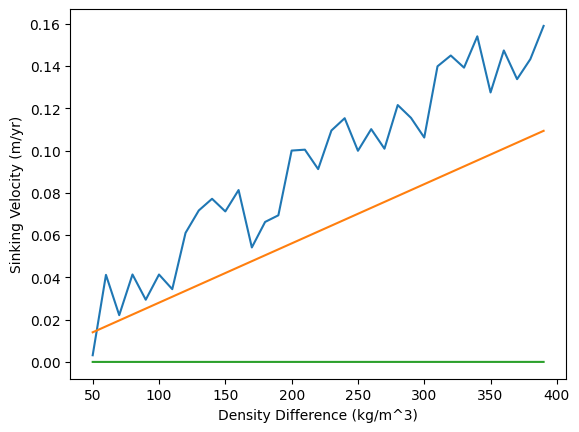

In [7]:
# load from a previous csv file
file_in = os.path.join(RESULT_DIR, "sink_v_data.csv")
assert(os.path.isfile(file_in))
sinkV_data = pd.read_csv(file_in)
drhos = sinkV_data["density_difference"]
sinkV = sinkV_data["sinking_velocity"] # take positive values
print("length of data:", len(drhos))

fig, ax = plt.subplots()
ax.plot(drhos, sinkV, label="perturbation")
ax.plot(drhos, StokesSinkAnalytic2d(_, _, drhos, 22), label="analytical solution, 1e22")
ax.plot(drhos, StokesSinkAnalytic2d(_, _, drhos, 26), label="analytical solution, 1e26")
ax.set_xlabel("Density Difference (kg/m^3)")
ax.set_ylabel("Sinking Velocity (m/yr)")

#### Start the pymc model

Here is the thoughts in building the model.
* log value of eta is the first prior. It's a continous variable, and we expect it to center around some constant value in this case. Thus we model it using a Normal distribution.
* we introduce a second prior, sigmaV, such that we allow our model to misfit the observation, with this value defines the standard error.
* Then we should be able to derive the values of the sinking velocity. The observed value should follow a normal distribution, with $\mu$ being the derived values and the standard error being the second prior, sigmaV.

There some technical issue we need to overcome here.

* Our function StokesSinkASPECT2d is basically a black box that runs the finite-element model beneath. So we need to make it compatible with PyMC syntax.
* We need to run this, many many times

To make things easier, I defined an analytical version in the previous section (StokesSinkAnalytic2d), we can switch to this easy options to debug our code.

In [8]:
year = 365 * 24 * 3600.0
g = 10.0
R = 200e3

prm_path_ori = os.path.join(mcmc_dir, "stokes_0", "stokes.prm")
assert(os.path.isfile(prm_path_ori))

parent_dir = os.path.join(mcmc_dir, "stokes_mcmc_2d")
if os.path.isdir(parent_dir):
    rmtree(parent_dir)
os.mkdir(parent_dir)


with pm.Model() as aspect_model:
    log_eta = pm.Normal("log_eta", mu=21.0, sigma=3.0)  # Intercept prior
    sigmaV = pm.HalfNormal("sigmaV", sigma=0.01) # Standard deviation prior

    # second approach: use deterministic
    # we handle two tasks within:
    #   1. we extract each of the drhos inputs and flatten the corresponding Tensor log_eta to pass only scalar values to
    #   our StokesSinkASPECT2d function
    #   2. We collect the outputs from this function, first into a list, and then stack it up to a Tensor for PyMC again.
    # a. using a tester approach - analytical solution
    # below is a stack of things that don't work ..., only the last, the complex syntax works ...
    # sinkV_model = -2.0 / 9.0 * (drhos * g * R**2.0) / pm.math.exp(log_eta*pm.math.log(10)) * year
    # sinkV_model = pm.Deterministic("sinkV_model", StokesSinkAnalytic2d(_, _, drhos, log_eta))
    sinkV_model = pm.Deterministic("sinkV_model",
         pm.math.stack([StokesSinkAnalytic2d(parent_dir, prm_path_ori, drhos[i], log_eta) for i in range(len(drhos))]))
    # print the shape: this doesn't print the tuple as in numpy, because it hasn't been sampled yet.
    # print("shape:", sinkV_model.shape)
    # b. call ASPECT in a black box
    # sinkV_model = pm.Deterministic("sinkV_model",
         # pm.math.stack([StokesSinkASPECT2d(parent_dir, prm_path_ori, drhos[i], log_eta[i].eval()) for i in range(len(drhos))]))

    # likelihood
    sinkV_obs = pm.Normal("sinkV_obs", mu=sinkV_model, sigma=sigmaV, observed=sinkV)

In [9]:
# debug

print("sinkV", sinkV)

sinkV 0     0.003158
1     0.041191
2     0.022119
3     0.041371
4     0.029423
5     0.041348
6     0.034417
7     0.061034
8     0.071650
9     0.077174
10    0.071199
11    0.081311
12    0.054153
13    0.066224
14    0.069367
15    0.099982
16    0.100414
17    0.091211
18    0.109481
19    0.115291
20    0.099884
21    0.110124
22    0.100873
23    0.121517
24    0.115462
25    0.106148
26    0.139845
27    0.144957
28    0.139220
29    0.154033
30    0.127480
31    0.147349
32    0.133768
33    0.143241
34    0.158953
Name: sinking_velocity, dtype: float64


In [10]:
with aspect_model:
    # Perform MCMC sampling using the NUTS sampler
    # the return_inferencedata=Fals3 is needed if we want to use trace as a dict
    # but this doesn't work with the summary
    trace = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_eta, sigmaV]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [11]:
# Summarize the trace and posterior
# the option return_inferencedata=False must be deleted
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_eta,21.831,0.009,21.813,21.848,0.0,0.0,3046.0,2621.0,1.0
sigmaV,0.013,0.002,0.010,0.015,0.0,0.0,3456.0,2939.0,1.0
sinkV_model[0],0.021,0.000,0.020,0.022,0.0,0.0,3046.0,2621.0,1.0
sinkV_model[1],0.025,0.001,0.024,0.026,0.0,0.0,3046.0,2621.0,1.0
sinkV_model[2],0.029,0.001,0.028,0.030,0.0,0.0,3046.0,2621.0,1.0
sinkV_model[3],0.033,0.001,0.032,0.034,0.0,0.0,3046.0,2621.0,1.0
sinkV_model[4],0.037,0.001,0.036,0.039,0.0,0.0,3046.0,2621.0,1.0
sinkV_model[5],0.041,0.001,0.040,0.043,0.0,0.0,3046.0,2621.0,1.0
sinkV_model[6],0.046,0.001,0.044,0.047,0.0,0.0,3046.0,2621.0,1.0
sinkV_model[7],0.050,0.001,0.048,0.052,0.0,0.0,3046.0,2621.0,1.0


array([[<Axes: title={'center': 'log_eta'}>,
        <Axes: title={'center': 'sigmaV'}>,
        <Axes: title={'center': 'sinkV_model\n0'}>,
        <Axes: title={'center': 'sinkV_model\n1'}>],
       [<Axes: title={'center': 'sinkV_model\n2'}>,
        <Axes: title={'center': 'sinkV_model\n3'}>,
        <Axes: title={'center': 'sinkV_model\n4'}>,
        <Axes: title={'center': 'sinkV_model\n5'}>],
       [<Axes: title={'center': 'sinkV_model\n6'}>,
        <Axes: title={'center': 'sinkV_model\n7'}>,
        <Axes: title={'center': 'sinkV_model\n8'}>,
        <Axes: title={'center': 'sinkV_model\n9'}>],
       [<Axes: title={'center': 'sinkV_model\n10'}>,
        <Axes: title={'center': 'sinkV_model\n11'}>,
        <Axes: title={'center': 'sinkV_model\n12'}>,
        <Axes: title={'center': 'sinkV_model\n13'}>],
       [<Axes: title={'center': 'sinkV_model\n14'}>,
        <Axes: title={'center': 'sinkV_model\n15'}>,
        <Axes: title={'center': 'sinkV_model\n16'}>,
        <Axes: t

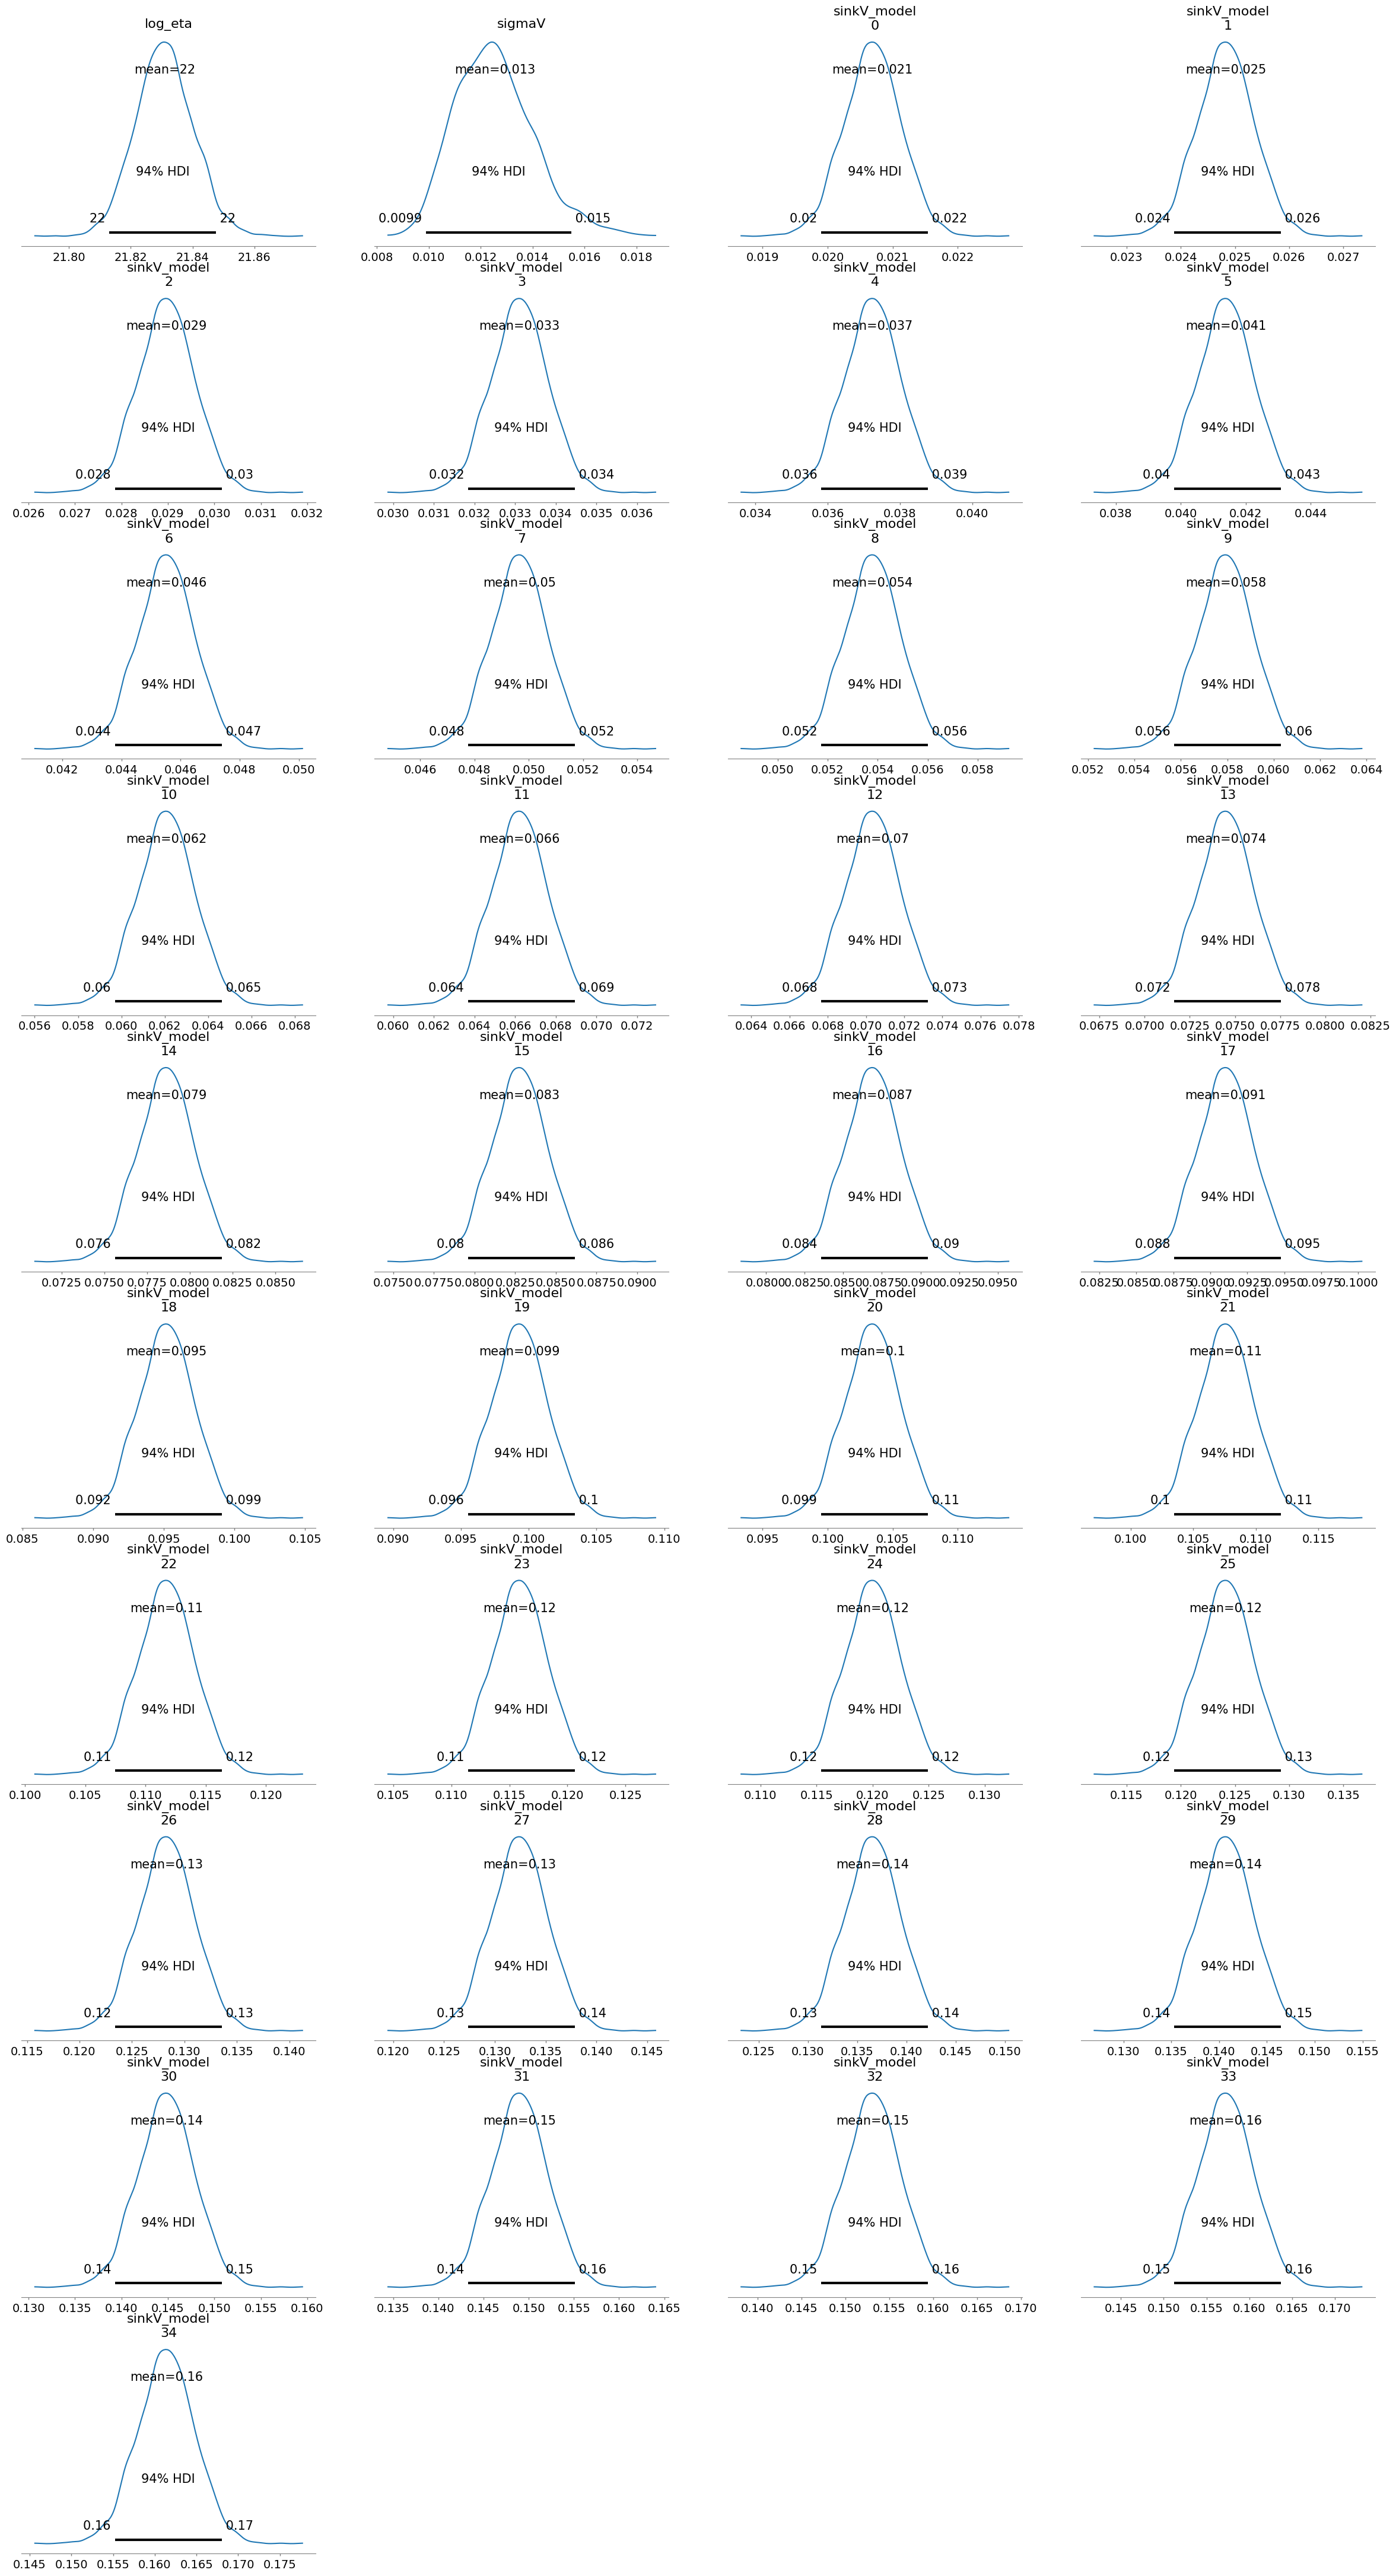

In [12]:
az.plot_posterior(trace)

### Diagnostics

#### Use az to plot the summary

array([<Axes: title={'center': 'log_eta\n0'}>,
       <Axes: title={'center': 'log_eta\n1'}>,
       <Axes: title={'center': 'log_eta\n2'}>,
       <Axes: title={'center': 'log_eta\n3'}>], dtype=object)

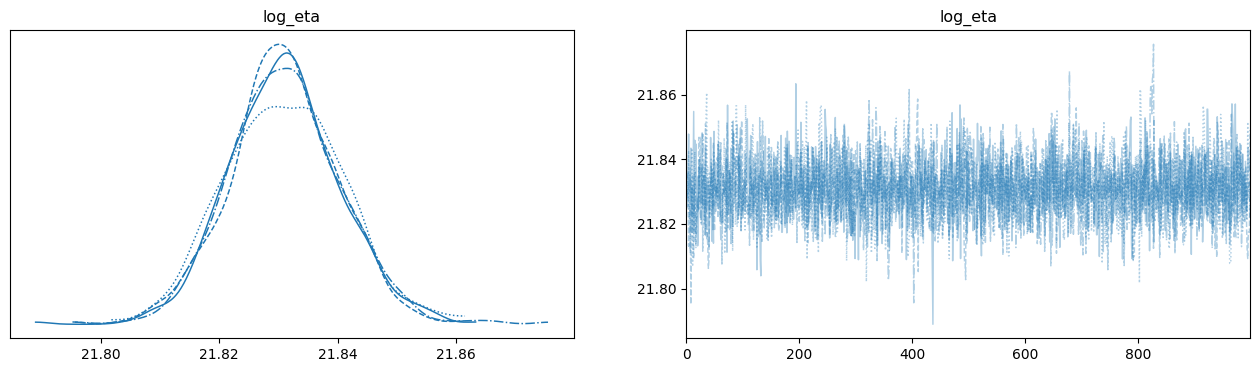

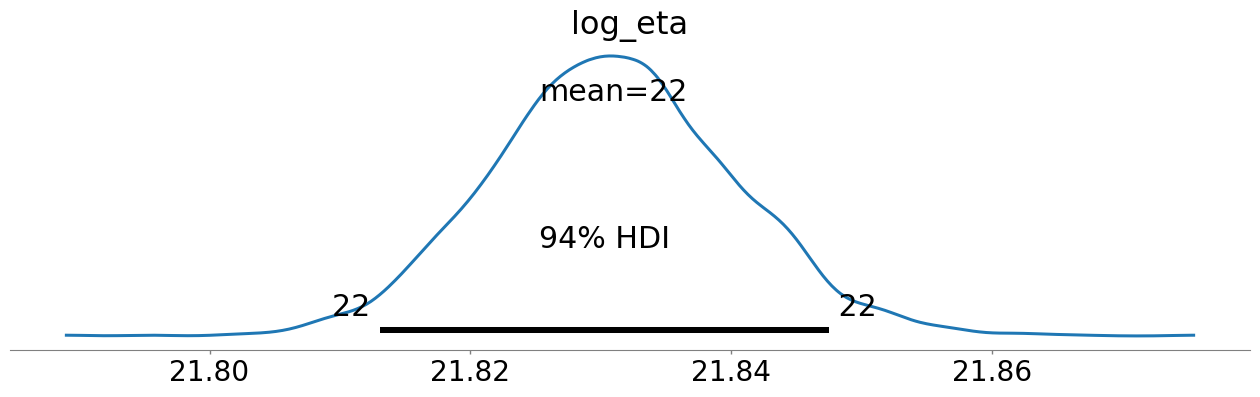

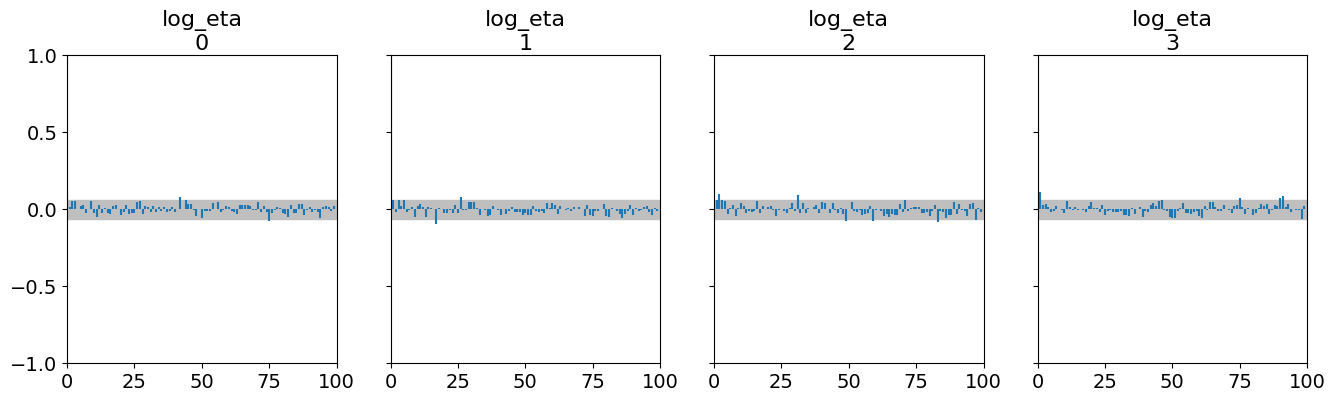

In [13]:
az.plot_trace(data=trace, var_names=["log_eta"], figsize=(16, 4))
az.plot_posterior(data=trace, var_names=["log_eta"], figsize=(16, 4))
az.plot_autocorr(data=trace, var_names=["log_eta"], figsize=(16, 4))

#### Try using the az.plot_ppc

Sampling: [sinkV_obs]


<Axes: xlabel='sinkV_obs'>

/home/lochy/anaconda3/envs/pyBayesian/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/lochy/anaconda3/envs/pyBayesian/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


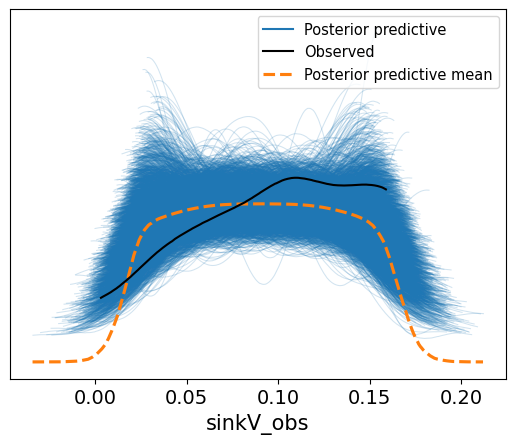

In [14]:
with aspect_model:
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["sinkV_obs"], extend_inferencedata=True, return_inferencedata=True)

# print(posterior_predictive["posterior_predictive"].sinkV_obs)

az.plot_ppc(posterior_predictive)

#### Proceed by first extracting the sample of the posteriors

In [15]:
log_eta_samples = np.concatenate(trace.posterior.log_eta.data[:,800:])[:, None]
sigmaV_samples = np.concatenate(trace.posterior.sigmaV.data[:,800:])[:, None]
drho_t = np.arange(drhos.min()-5.0, drhos.max()+5.0, 1.0)[:, None]
sinkV_t = StokesSinkAnalytic2d(_, _, drho_t.T, log_eta_samples)

mean_sinkV_t = sinkV_t.mean(axis=0)

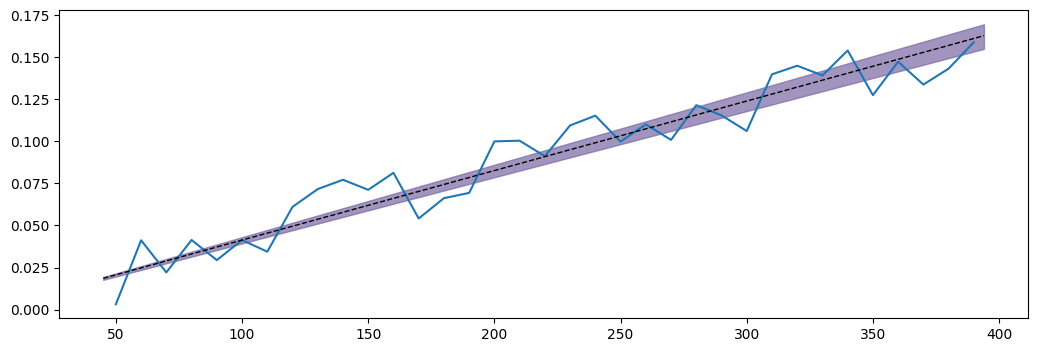

In [16]:
figsize(12.5, 4)
qs = mquantiles(sinkV_t, [0.025, 0.975], axis=0)
plt.plot(drhos, sinkV, label="synthetic data")
plt.fill_between(drho_t[:, 0], *qs, alpha=0.7, color="#7A68A6")
plt.plot(drho_t, mean_sinkV_t, lw=1, ls="--", color='k', label="average posterior \nsinking \
velocity")